# Temporal Anomaly Detection Dataset Challenge
Suppose our business is a pop-up store and relies on selling items to large groups of people.

We seek to make critical business decisions of where to locate our business based on anomalous activity on a certain pedestrian trail in Seattle. If there is an unusual amount of activity on the trail, we would like to relocate to the trail. Otherwise, we would find another location.

The dataset you will be using is collected by the City of Seattle using a combination of infrared and pressure sensors and consists of 5 features about the trail.

Your task is to create an anomaly detection model which can use these features to determine if the activity on the trail 3 hours in the future will be anomalous

#### Project specifications:
- Create an anomaly detection model to predict anomalies 3 hours in the future
- Provide clear visualizations to explain your results
- Consider experimental design choices for the results to be valid in production
- Describe how you would use these results to recommend an action to the business
- Please spend about 3 hours on this challenge
    - If you have extra time, please consider doing another investigation with the data that you think could help the business owners. This is completely optional and will only be used to kickstart our discussions of your work


<b>Definition of Anomalous</b>: The criteria for anomalous activity is at least 500 total people on the trail in the past
hour.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, Normalizer

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler

from typing import List, Union
from abc import ABC, abstractmethod
from collections import defaultdict
import time
import os


In [2]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_dir = "../data"
fname = "burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv"
data_fpath = os.path.join(data_dir, fname)

## Data Pre-Processing

In [4]:
def split_datetime_features(df:pd.DataFrame) -> pd.DataFrame:

    df['Date'] = pd.to_datetime(df['Date'])

    df['Ped Total'] = df['Ped North'] + df['Ped South']
    df['Bike Total'] = df['Bike North'] + df['Bike South']

    df['Day'] = df[ "Date"].dt.day
    df['Hour'] = df[ "Date"].dt.hour

    df['Day of Week'] = df[ "Date"].dt.dayofweek
    df['Month'] = df["Date"].dt.month
    df['Year'] = df[ "Date"].dt.year
    return df

def handle_missing_data(df:pd.DataFrame) -> pd.DataFrame:

    # Handle Null Data not in Gap
    df[df.Year.ne(2018)] = df[df.Year.ne(2018)].fillna(method="ffill")
    df[df.Year.ne(2018)] = df[df.Year.ne(2018)].fillna(method="bfill")
    df[df.Year.eq(2018) & df.Month.lt(6)] = df[df.Year.eq(2018) & df.Month.lt(6)].fillna(method='ffill')

    # Handle Null Data within Gap
    gap_min_month, gap_max_month = df[df.isna().any(axis=1)]['Month'].min(), df[df.isna().any(axis=1)]['Month'].max()
    df_null = df[df.isna().any(axis=1)]
    print(f"Gap Min Month: {gap_min_month}\nGap Max Month: {gap_max_month}")

    # TODO: optimize this algorithm
    for i, row in df_null.iterrows():
        metrics = {
            'BGT North of NE 70th Total': [],
            'Ped South': [],
            'Ped North': [],
            'Bike North': [],
            'Bike South': [],
            'Ped Total': [],
            'Bike Total':[]
        }
        missing_dt = row['Date']
        for year in df.Year.unique():
            if year == 2018: continue
            offset =  year - missing_dt.year
            curr_dt = missing_dt + pd.offsets.DateOffset(years=offset)
            curr_row = df[df.Date.eq(curr_dt)]
            if len(curr_row.index) != 1: continue
            for k, v in metrics.items(): metrics[k].append(curr_row[k].values[0])
            
        for k, v in metrics.items(): 
            mean_val = np.average(metrics[k])
            df.at[i, k] = float(round(mean_val))
    
    return df


def create_lags(df:pd.DataFrame, target_col:str, lag:int=3) -> pd.DataFrame:
    for i in range(lag): df[f"t-{i+1}"] = df[target_col].shift(i+1)
    df["t"] = df[target_col]
    return df

def create_futures(df:pd.DataFrame, target_col:str, lag:int=3) -> pd.DataFrame:
    for i in range(lag): df[f"t+{i+1}"] = df[target_col].shift(-(i+1))
    return df

def preprocess(df:pd.DataFrame, target_col:str, lag:int=3) -> pd.DataFrame:
    df = split_datetime_features(df)
    df = handle_missing_data(df)

    df['BGT North of NE 70th Total'] = df['BGT North of NE 70th Total'].astype(np.int64)
    df['Ped South'] = df['Ped South'].astype(np.int64)
    df['Ped North'] = df['Ped North'].astype(np.int64)
    df['Bike North'] = df['Bike North'].astype(np.int64)
    df['Bike South'] = df['Bike South'].astype(np.int64)
    df['Ped Total'] = df['Ped Total'].astype(np.int64)
    df['Bike Total'] = df['Bike Total'].astype(np.int64)

    df = create_lags(df, target_col, lag=lag)
    df = create_futures(df, target_col, lag=lag)

    df.dropna(inplace=True)
    for i in range(lag): 
        df[f"t-{i+1}"] = df[f"t-{i+1}"].astype(np.int64)
        df[f"t+{i+1}"] = df[f"t+{i+1}"].astype(np.int64)
    
    df.drop_duplicates(inplace=True)
    df.drop(columns=['Month', 'Day of Week', 'Hour', 'Day', 'BGT North of NE 70th Total'], inplace=True)

    df = df.sort_values(by="Date", ascending=True)
    df = df.reset_index(drop=True)

    return df


In [5]:
def plot_features(
    df:pd.DataFrame, 
    index:str="Date", 
    features:List[str]=['Ped Total', 'Bike Total'],
    plot_type:str="line",
    xlim:tuple=None,
    ylim:tuple=None,
):
    """Function to plot features with respect to a given index

    Args:
        df (pd.DataFrame): data DataFrame
        index (str, optional): column to use as the x-axis. Defaults to "Date".
        features (List[str], optional): list of feature columns to use along y-axis. Defaults to ['Ped Total', 'Bike Total'].
        plot_type (str, optional): type of plot to create. Defaults to "line". See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html
        xlim (tuple, optional): lmits on x-axis. Defaults to None.
        ylim (tuple, optional): limits on y-axis. Defaults to None.
    """
    colors = ['b','g', 'r']
    all_cols = [index] + features
    df_temp = df[all_cols]
    ax = None
    for i, feat in enumerate(features):
        ax = df_temp.plot(
            index, 
            feat, 
            kind=plot_type, 
            ax=ax, 
            label=feat, 
            color=colors[i],
            xlim=xlim,
            ylim=ylim
        )
        ax.set_xlabel(index)
        ax.set_ylabel("Counts")

In [6]:
df = pd.read_csv(data_fpath)
print(df.head())


df = preprocess(df, 'BGT North of NE 70th Total', lag=3)

df

                      Date  BGT North of NE 70th Total  Ped South  Ped North  \
0  2014-01-01T00:00:00.000                        15.0        0.0        2.0   
1  2014-01-01T01:00:00.000                         9.0        1.0        0.0   
2  2014-01-01T02:00:00.000                         9.0        0.0        0.0   
3  2014-01-01T03:00:00.000                        19.0        0.0        0.0   
4  2014-01-01T04:00:00.000                        19.0        0.0        0.0   

   Bike North  Bike South  
0         2.0        11.0  
1         1.0         7.0  
2         0.0         9.0  
3         0.0        19.0  
4         0.0        19.0  
Gap Min Month: 6
Gap Max Month: 9


KeyboardInterrupt: 

In [ ]:
df.describe()

,Ped South,Ped North,Bike North,Bike South,Ped Total,Bike Total,Year,t-1,t-2,t-3,t,t+1,t+2,t+3
count,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000,52578.000000
mean,20.035490,9.846438,22.522956,22.561832,29.882822,45.085872,2016.499772,74.969055,74.969113,74.969132,74.968922,74.968618,74.968276,74.968047
std,133.151977,40.760178,33.458066,61.567203,159.109882,80.273103,1.707374,188.491009,188.490989,188.490983,188.491058,188.491162,188.491280,188.491361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2015.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,5.000000,5.000000,8.000000,9.000000,11.000000,20.000000,2016.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
75%,14.000000,13.000000,32.000000,34.000000,27.000000,67.000000,2018.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
max,4054.000000,4095.000000,794.000000,8191.000000,5118.000000,8191.000000,2019.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000,10493.000000


## Visualize Preprocessed Data

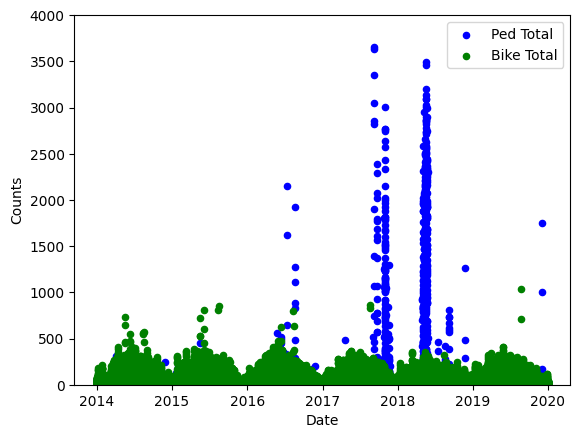

In [ ]:
plot_features(
    df, 
    index="Date", 
    features=['Ped Total', 'Bike Total'],  
    plot_type="scatter",
    ylim=(0, 4000)
)

## Datasets

In [ ]:
class CountDataset:
    def __init__(self, df:pd.DataFrame, target_col:str, classification:bool=False) -> None:

        self.df = df
        if 'Date' in list(df.columns): df = df.drop(columns=['Date'])
        self.X, self.Y = self.split_x_y(df, target_col, classification=classification)

    def split_x_y(self, df:pd.DataFrame, target_col:str, classification:bool=False) -> Union[np.ndarray, np.ndarray]:
        X = df.loc[:, df.columns != target_col]
        Y = df[target_col].values
        if classification: Y = df['y_class'].values

        X = X.loc[:, X.columns != 'y_class'].values
        return X, Y
    
    def as_np_array(self):
        self.X, self.Y = np.array(self.X), np.array(self.Y)

    def as_torch_tensor(self):
        self.X, self.Y = torch.tensor(self.X), torch.tensor(self.Y)
    
def classify_counts(counts:np.ndarray, threshold:int=500) -> np.ndarray:
    count_classes = []
    for i in range(len(counts)):
        if counts[i] >= threshold: count_classes.append(1)
        else: count_classes.append(0)

    return np.array(count_classes)

def create_datasets(
    df:pd.DataFrame, 
    feature_cols:list, 
    target_col:str="t",
    include_val:bool=False,
    classification:bool=False
) -> Union[CountDataset, CountDataset, CountDataset]:

    df_temp = df[['Date'] + feature_cols + [target_col] + ['Year']]
    df_temp['y_class'] = classify_counts(df[target_col].values)

    test = df_temp[df_temp.Year.ge(2018)]
    if include_val:
        train = df_temp[df_temp.Year.ge(2014) & df_temp.Year.lt(2017)]
        val = df_temp[df_temp.Year.ge(2017) & df_temp.Year.lt(2018)]
    else:
        train = df_temp[df_temp.Year.ge(2014) & df_temp.Year.lt(2018)]
        val = df_temp.iloc[0:0]

    
    train, val, test = train.drop(columns=['Year']), val.drop(columns=['Year']), test.drop(columns=['Year'])
    train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)
    train = CountDataset(train, target_col, classification=classification)
    val = CountDataset(val, target_col, classification=classification)
    test = CountDataset(test, target_col, classification=classification)

    return train, val, test
    

In [ ]:
train, val , test = create_datasets(
    df, 
    feature_cols=["Ped Total", "Bike Total", "t", "t-1", 't-2', 't-3'],
    target_col="t+3",
    classification=False
)

print(train.X.shape, train.Y.shape)
print(val.X.shape, val.Y.shape)
print(test.X.shape, test.Y.shape)

print(test.X[:3])
print(test.Y[:10])

test.df.head()

(35061, 4) (35061,)
(0, 4) (0,)
(17517, 4) (17517,)
[[0 1 1 1]
 [0 5 5 1]
 [0 4 4 5]]
[  0   0   0   2   3   8  39  71 101 130]


/tmp/ipykernel_9752/2764571899.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['y_class'] = classify_counts(df[target_col].values)


,Date,Ped Total,Bike Total,t,t-1,t+3,y_class
0,2018-01-01 00:00:00,0,1,1,1,0,0
1,2018-01-01 01:00:00,0,5,5,1,0,0
2,2018-01-01 02:00:00,0,4,4,5,0,0
3,2018-01-01 03:00:00,0,0,0,4,2,0
4,2018-01-01 04:00:00,0,0,0,0,3,0


## Model Training and Evaluation Pipeline

In [ ]:
class ModelTemplate(ABC):
    def __init__(self, *args, **kwargs) -> None:
        pass
    
    @abstractmethod
    def train(self, *args, **kwargs):
        pass
    
    @abstractmethod
    def predict(self,*args, **kwargs):
        pass



### A. Baseline Model

In [ ]:
class MovingAverageModel(ModelTemplate):
    def __init__(self, window:int=10, col:str="t") -> None:
        super().__init__(window=window)
        self.window = window
        self.col = col
    
    def train(self, X, Y):
        pass

    def predict(self, test_df:pd.DataFrame):
        df = test_df
        df['ma'] = df[self.col].rolling(self.window).mean()
        for i, row in df.iterrows():
            if pd.isnull(row['ma']): 
                df.at[i,'ma'] = df.iloc[i]['t']

        df['ma'] = df['ma'].astype(np.int64)

        ret = df['ma'].values
        return ret
    

In [ ]:
model = MovingAverageModel(window=3)
preds = model.predict(test.df)

print(test.X.shape, test.Y.shape, preds.shape)
print(preds[:10])

print(test.df.head())

(17517, 4) (17517,) (17517,)
[ 1  5  3  3  1  0  0  1  4 16]
                 Date  Ped Total  Bike Total  t  t-1  t+3  y_class  ma
0 2018-01-01 00:00:00          0           1  1    1    0        0   1
1 2018-01-01 01:00:00          0           5  5    1    0        0   5
2 2018-01-01 02:00:00          0           4  4    5    0        0   3
3 2018-01-01 03:00:00          0           0  0    4    2        0   3
4 2018-01-01 04:00:00          0           0  0    0    3        0   1


### Model Evaluation

In [ ]:

def plot_predictions(
    test:CountDataset, 
    preds, 
    index_col:str='Date', 
    target_col:str='t+3',
    start_index:int=0, 
    end_index:int=-1,
    show_preds_only:bool=False
):
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('Predicted versus actual counts')
    if end_index == -1:
        predicted, = plt.plot(test.df[index_col], preds, 'go-', label='Predicted counts')
    else:
        predicted, = plt.plot(test.df.iloc[start_index:end_index][index_col], preds, 'go-', label='Predicted counts')
    plt.legend(handles=[predicted])
    if not show_preds_only:
        if end_index == -1:
            actual, = plt.plot(test.df[index_col],test.df[target_col].values, 'ro-', label='Actual counts')
        else:
            actual, = plt.plot(test.df.iloc[start_index:end_index][index_col],test.df.iloc[start_index:end_index][target_col].values, 'ro-', label='Actual counts')

        plt.legend(handles=[predicted, actual])
    
    plt.show()


def filter_anomalies(y_class:np.ndarray, pred_class:np.ndarray) -> Union[np.ndarray, np.ndarray]:

    filtered_y, filtered_preds = [], []
    for i in range(len(y_class)):
        if y_class[i] == 1: 
            filtered_y.append(y_class[i])
            filtered_preds.append(pred_class[i])

    return filtered_y, filtered_preds


def calculate_metrics(y_class:np.ndarray, pred_class:np.ndarray) -> dict:
    balanced_acc = metrics.balanced_accuracy_score(y_class, pred_class)
    precision = metrics.precision_score(y_class, pred_class)
    recall = metrics.recall_score(y_class, pred_class)

    metrics_dict = {
        'balanced_acc': round(balanced_acc, 3),
        'precision': round(precision, 3),
        'recall': round(recall, 3)
    }

    return metrics_dict



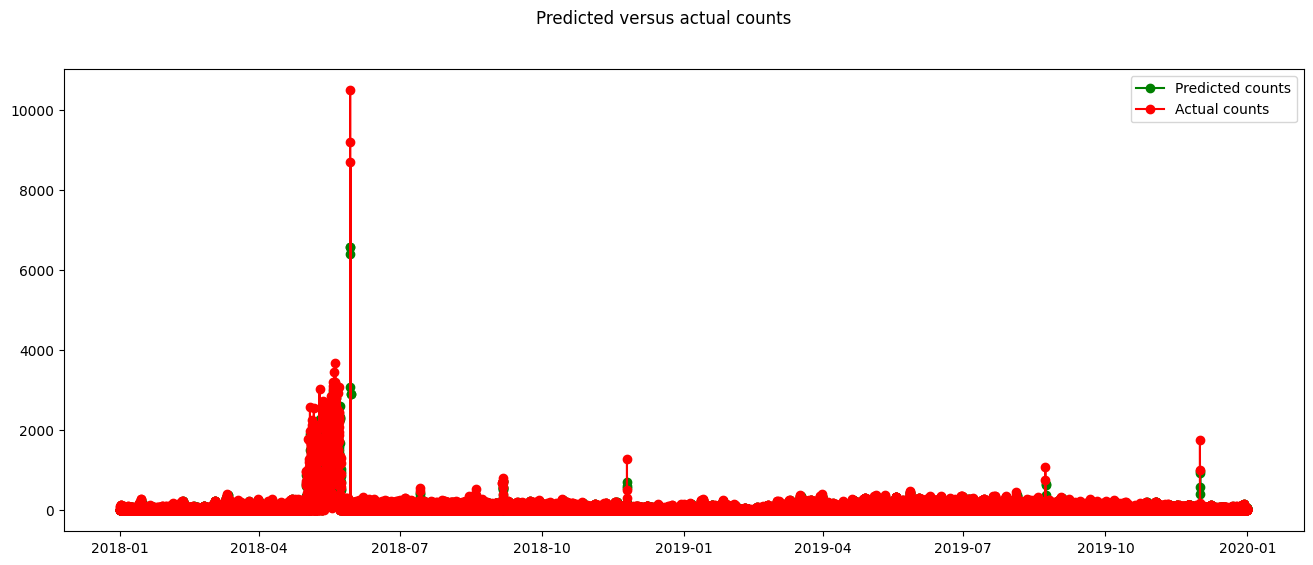

In [ ]:
plot_predictions(test, preds)

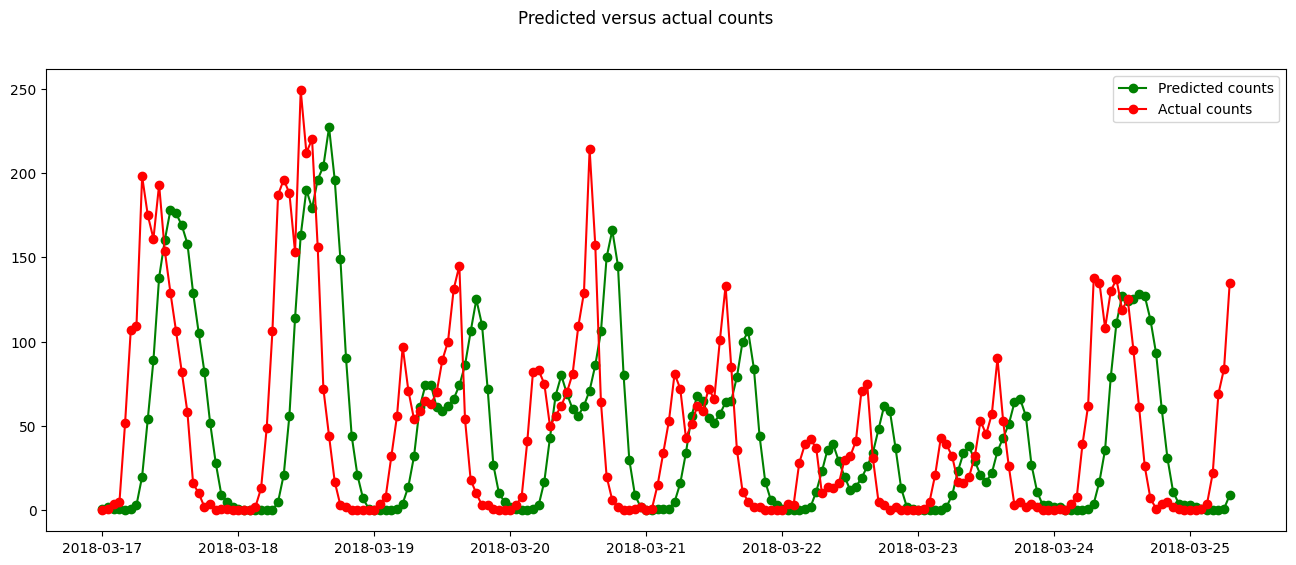

In [ ]:
plot_predictions(test, preds[1800:2000], start_index=1800, end_index=2000)

In [ ]:
y_class, pred_class = classify_counts(test.Y), classify_counts(preds)

print(y_class.shape, pred_class.shape)
calculate_metrics(y_class, pred_class)

(17517,) (17517,)


{'balanced_acc': 0.886, 'precision': 0.737, 'recall': 0.777}

In [ ]:
test.df['pred_class'] = pred_class
test.df[test.df['t+3'].ge(400)].head(15)

,Date,Ped Total,Bike Total,t,t-1,t+3,y_class,ma,pred_class
1668,2018-03-11 12:00:00,39,257,296,232,412,0,230,0
2889,2018-05-01 09:00:00,31,61,92,239,973,1,159,0
2890,2018-05-01 10:00:00,21,38,59,92,962,1,130,0
2891,2018-05-01 11:00:00,21,33,54,59,738,1,68,0
2894,2018-05-01 14:00:00,701,37,738,962,620,1,891,1
2897,2018-05-01 17:00:00,420,200,620,169,670,1,294,0
2908,2018-05-02 04:00:00,85,2,87,108,425,0,65,0
2912,2018-05-02 08:00:00,18,148,166,425,864,1,216,0
2914,2018-05-02 10:00:00,17,61,78,134,931,1,126,0
2915,2018-05-02 11:00:00,787,77,864,78,921,1,358,0


### B. Deep Learning Models

In [ ]:

def create_regression_datasets(
    df:pd.DataFrame, 
    feature_cols:list, 
    target_col:str="t",
    include_val:bool=False,
    classification:bool=False
) -> Union[CountDataset, CountDataset, CountDataset]:

    df_temp = df[['Date'] + feature_cols + [target_col] + ['Year']]
    df_temp.loc[:,'y_class'] = classify_counts(df[target_col].values)

    test = df_temp[df_temp.Year.ge(2018)]
    df_train_val = df_temp[df_temp.Year.lt(2018)]
    
    if include_val:
        train = df_train_val[df_train_val.Year.ge(2014) & df_train_val.Year.lt(2017)]
        val = df_train_val[df_train_val.Year.ge(2017) & df_train_val.Year.lt(2018)]
    else:
        train = df_train_val[df_temp.Year.ge(2014) & df_train_val.Year.lt(2018)]
        val = df_train_val.iloc[0:0]
    
    # scale based on training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train.loc[:,target_col] = scaler.fit_transform(train[target_col].values.reshape(-1,1))
    val.loc[:,target_col] = scaler.transform(val[target_col].values.reshape(-1,1))
    test.loc[:,target_col] = scaler.transform(test[target_col].values.reshape(-1,1))

    feature_scaler = MinMaxScaler(feature_range=(-1, 1))
    for col in feature_cols:
        train.loc[:,col] = feature_scaler.fit_transform(train[col].values.reshape(-1,1))
        val.loc[:,col] = feature_scaler.transform(val[col].values.reshape(-1,1))
        test.loc[:,col] = feature_scaler.transform(test[col].values.reshape(-1,1))

    train, val, test = train.drop(columns=['Year']), val.drop(columns=['Year']), test.drop(columns=['Year'])
    train, val, test = train.reset_index(drop=True), val.reset_index(drop=True), test.reset_index(drop=True)
    train = CountDataset(train, target_col, classification=classification)
    val = CountDataset(val, target_col, classification=classification)
    test = CountDataset(test, target_col, classification=classification)

    return train, val, test, feature_scaler, scaler


train, val, test, feature_scaler, scaler = create_regression_datasets(
    df, 
    feature_cols=["t", "t-1", 't-2', 't-3'],
    target_col="t+3",
    classification=False,
    include_val=True
)

print(train.df.describe())

print(train.X.shape, train.Y.shape)
print(val.X.shape, val.Y.shape)
print(test.X.shape, test.Y.shape)

print(test.X[:3])
print(test.Y[:10])

                  t           t-1           t-2           t-3           t+3  \
count  26301.000000  26301.000000  26301.000000  26301.000000  26301.000000   
mean      -0.943773     -0.943773     -0.943772     -0.943772     -0.943775   
std        0.073477      0.073477      0.073477      0.073477      0.073478   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.997335     -0.997335     -0.997335     -0.997335     -0.997335   
50%       -0.969791     -0.969791     -0.969791     -0.969791     -0.969791   
75%       -0.912928     -0.912928     -0.912928     -0.912928     -0.912928   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            y_class  
count  26301.000000  
mean       0.001635  
std        0.040402  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  
(26301, 4) (26301,)
(8760, 4) (8760,)
(17517, 4) (17517,)
[[-0.99911151 -0.99911151 -0.998

/tmp/ipykernel_9752/205728667.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[:,'y_class'] = classify_counts(df[target_col].values)
/tmp/ipykernel_9752/205728667.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,target_col] = scaler.fit_transform(train[target_col].values.reshape(-1,1))
/tmp/ipykernel_9752/205728667.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [ ]:
print(train.X[:3], train.Y[:3])

[[-0.98311861 -0.99200355 -0.99200355 -0.98667259]
 [-0.98311861 -0.98311861 -0.99200355 -0.99200355]
 [-0.98756108 -0.98311861 -0.98311861 -0.99200355]] [-0.99111506 -0.99111506 -0.97601066]


In [ ]:
train.df.head()

,Date,t,t-1,t-2,t-3,t+3,y_class
0,2014-01-01 03:00:00,-0.983119,-0.992004,-0.992004,-0.986673,-0.991115,0
1,2014-01-01 04:00:00,-0.983119,-0.983119,-0.992004,-0.992004,-0.991115,0
2,2014-01-01 05:00:00,-0.987561,-0.983119,-0.983119,-0.992004,-0.976011,0
3,2014-01-01 06:00:00,-0.991115,-0.987561,-0.983119,-0.983119,-0.974234,0
4,2014-01-01 07:00:00,-0.991115,-0.991115,-0.987561,-0.983119,-0.937805,0


In [ ]:
train.Y[3]

-0.974233673922701

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, X:List[np.ndarray], Y:List[np.ndarray]):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    

def create_direct_target_sequences(
    data:CountDataset, 
    context_seq_length:int=200,
    pred_seq_length:int=3
) -> Union[List[np.ndarray], List[np.ndarray]]:
    
    X, Y = [], []
    for i in range(len(data.Y)-context_seq_length-1):
        x = data.X[i:i+context_seq_length]
        target_index =i+context_seq_length+pred_seq_length-1
        if target_index >= len(data.Y): continue 
        y = data.Y[target_index]
                
        if x.shape != (context_seq_length, data.X.shape[1]): continue
        X.append(x)
        Y.append(y)
    return X, Y


def create_seq2seq_sequences(
    data:CountDataset, 
    context_seq_length:int=30,
    pred_seq_length:int=3
) -> Union[List[np.ndarray], List[np.ndarray]]:
    
    X, Y = [], []
    for i in range(len(data.Y)-context_seq_length-1):
        x = data.X[i:i+context_seq_length]
        y = data.Y[i+context_seq_length:i+context_seq_length+pred_seq_length]
        if x.shape != (context_seq_length, data.X.shape[1]) or y.shape!=(pred_seq_length,): continue
        X.append(x)
        Y.append(y)
    return X, Y


class LSTM(nn.Module):
    def __init__(
        self, 
        num_classes:int=1,
        input_size:int=4,
        hidden_size:int=12,
        num_layers:int=2,
        batch_first:bool=True,
        device:str="cpu"
    ) -> None:
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.device = device
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=batch_first
        )
        self.linear = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.linear(out)
        return out

class Seq2SeqLSTM(nn.Module):
    def __init__(
        num_classes:int=1,
        input_size:int=4,
        hiden_size:int=512,
        num_layers:int=2,
        output_seq_length:int=3,
        batch_first:bool=True
    ) -> None:
        super(Seq2SeqLSTM, self).__init__()
    
    def forward(self, x):
        pass



In [ ]:
## Hypeparams
batch_size = 10
n_epochs = 100
max_lr = 0.0005
lr_step_size = 10
lr_update = 0.00001
context_seq_length = 76

## Define Datasets and Dataloaders
trainX, trainY = create_direct_target_sequences(train, context_seq_length=context_seq_length, pred_seq_length=3)
valX, valY = create_direct_target_sequences(val, context_seq_length=context_seq_length, pred_seq_length=3)
testX, testY = create_direct_target_sequences(test, context_seq_length=context_seq_length, pred_seq_length=3)

train_ds = SequenceDataset(trainX, trainY)
val_ds = SequenceDataset(valX, valY)
test_ds = SequenceDataset(testX, testY)

data_loaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=0)
}

## Define model, optimizer, scheduler
# model params
input_size = trainX[0].shape[1]
hidden_size = 128
num_classes = 1
num_layers = 1

# model = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
model = LSTM(
    num_classes=num_classes,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=True,
    device=device
)
criterion = nn.MSELoss().to(device)
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=max_lr)
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_update)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=20, factor=0.5, min_lr=1e-7, eps=1e-08)

# instantiate model and send to device
model = model.to(device)
model

LSTM(
  (lstm): LSTM(4, 128, batch_first=True)
  (linear): Sequential(
    (0): ReLU()
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [ ]:
best_loss = np.inf
checkpoint_path = "lstm.pth"
stats = []

for epoch in range(n_epochs):
    print(f"\nEpoch: {epoch}/{n_epochs-1}\n{'-'*20}")
    epoch_start = time.time()
    train_loss, val_loss = None, None

    for phase in ['train', 'val']:
        if phase == 'train': model.train()
        else: model.eval()

        mets, epoch_samples = defaultdict(float), 0

        for i, (inputs, targets) in enumerate(data_loaders[phase]):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase=='train'):
                outputs = model(inputs.float())
                targets = targets.unsqueeze(1)
                loss = criterion(outputs, targets.float())
                # print(outputs, targets, loss)
                mets['loss'] += loss.item() * outputs.size(0)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_samples += inputs.size(0)

        metric_strings = [f"{k}:{round(mets[k]/epoch_samples, 6)}" for k in mets.keys()]
        print(f"{phase}: {', '.join(metric_strings)}")

        epoch_loss = mets['loss'] / epoch_samples

        if phase == 'train': train_loss = epoch_loss
        else: val_loss = epoch_loss
        
        if phase == 'val':
            scheduler.step(val_loss)
            for param_group in optimizer.param_groups: print("LR", param_group['lr'])

            if epoch_loss < best_loss:
                print(f"Saving Best Model to: {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

    stats.append([train_loss, val_loss])
    time_elapsed = time.time() - epoch_start
    print(f'Elapsed Time: {round(time_elapsed//60, 4)}m {round(time_elapsed%60, 4)}s')


                


Epoch: 0/99
--------------------
train: loss:0.01258
val: loss:0.030508
LR 0.0005
Saving Best Model to: lstm.pth
Elapsed Time: 0.0m 6.7355s

Epoch: 1/99
--------------------
train: loss:0.005555
val: loss:0.030791
LR 0.0005
Elapsed Time: 0.0m 6.0917s

Epoch: 2/99
--------------------
train: loss:0.005397
val: loss:0.029406
LR 0.0005
Saving Best Model to: lstm.pth
Elapsed Time: 0.0m 6.2073s

Epoch: 3/99
--------------------
train: loss:0.003003
val: loss:0.024527
LR 0.0005
Saving Best Model to: lstm.pth
Elapsed Time: 0.0m 6.1969s

Epoch: 4/99
--------------------
train: loss:0.002806
val: loss:0.024167
LR 0.0005
Saving Best Model to: lstm.pth
Elapsed Time: 0.0m 5.9134s

Epoch: 5/99
--------------------
train: loss:0.002716
val: loss:0.024866
LR 0.0005
Elapsed Time: 0.0m 5.8704s

Epoch: 6/99
--------------------
train: loss:0.002654
val: loss:0.024178
LR 0.0005
Elapsed Time: 0.0m 6.0092s

Epoch: 7/99
--------------------
train: loss:0.002626
val: loss:0.024806
LR 0.0005
Elapsed Time: 0.

KeyboardInterrupt: 

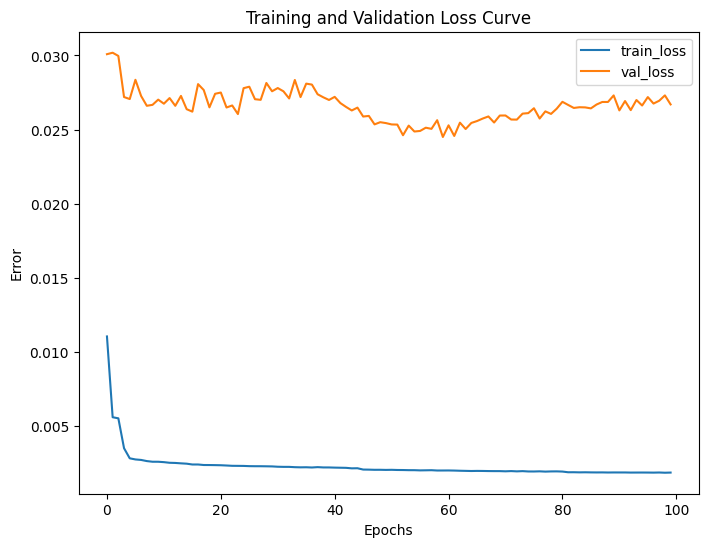

In [ ]:
df_stats = pd.DataFrame(stats, columns=['train_loss', 'val_loss'])
plt.figure(figsize=(8,6))

for c in ['train_loss', 'val_loss']: plt.plot(df_stats[c], label=c)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Loss Curve')
plt.show()


In [ ]:
def evaluate_lstm(
    model,
    feature_scaler, 
    target_scaler,
    df:pd.DataFrame,
    min_year_test=2018,
    feature_cols=["t", "t-1"],
    target_col='t+3',
    class_col='y_class',
    x_seq_length=730
):
    # preprocess and get test dataset
    print("1. Pre-processing Test Dataset...")
    df_temp = df
    df_temp['y_class'] = classify_counts(df[target_col].values)

    for col in feature_cols: 
        df_temp[col] = feature_scaler.transform(df_temp[col].values.reshape(-1,1))
        
    # df_temp[target_col] = scaler.transform(df_temp[target_col].values.reshape(-1,1))

    df_test = df_temp[df_temp.Year.ge(min_year_test)]
    filter_cols = feature_cols+[target_col]+[class_col]
    df_temp = df_temp[filter_cols]
    df_test = df_test[filter_cols]

    print(df_test.head(10))

    # get input sequences
    print("2. Creating Input Sequences...")
    x_sequences = []
    for i, row in df_test.iterrows():
        df_seq = df_temp.iloc[i-x_seq_length+1:i+1]
        df_seq = df_seq[feature_cols]
        np_seq = df_seq.values
        if np_seq.shape != (x_seq_length, len(feature_cols)): print(i, np_seq.shape)
        x_sequences.append(np_seq)
    
    print(f"\tProduced: {len(x_sequences)} sequences")

    # predict on each sequence
    # TODO: optimize by batching
    print("3. Running Inference...")
    model = model.to(device)
    model.eval()
    preds = []
    for i, seq in enumerate(x_sequences):
        inputs = torch.tensor(seq).to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs.float())
        inverse_outs = target_scaler.inverse_transform(outputs.detach().cpu().numpy())
        inverse_outs = round(inverse_outs.item())
        preds.append(inverse_outs)

    print(f"\tProduced: {len(preds)} predictions")

    # format output
    print("2. Formatting Outputs...")
    preds = np.array(preds)
    pred_class = classify_counts(preds)
    y = df_test[target_col]
    y_class = df_test['y_class'].values
    
    df_test = df[df.Year.ge(min_year_test)]
    df_test = df_test.reset_index(drop=True)

    return df_test, preds, y, pred_class, y_class


def plot_lstm_predictions(
    df_test:pd.DataFrame, 
    preds, 
    index_col:str='Date', 
    target_col:str='t+3',
    start_index:int=0, 
    end_index:int=-1,
    show_preds_only:bool=False
):
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('Predicted versus actual counts')
    if end_index == -1:
        predicted, = plt.plot(df_test[index_col], preds, 'go-', label='Predicted counts')
    else:
        predicted, = plt.plot(df_test.iloc[start_index:end_index][index_col], preds, 'go-', label='Predicted counts')
    plt.legend(handles=[predicted])
    if not show_preds_only:
        if end_index == -1:
            actual, = plt.plot(df_test[index_col],df_test[target_col].values, 'ro-', label='Actual counts')
        else:
            actual, = plt.plot(df_test.iloc[start_index:end_index][index_col],df_test.iloc[start_index:end_index][target_col].values, 'ro-', label='Actual counts')

        plt.legend(handles=[predicted, actual])
    
    plt.show()


In [ ]:
model = LSTM(
    num_classes=num_classes,
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    batch_first=True,
    device=device
)
model.load_state_dict(torch.load(checkpoint_path))
model

LSTM(
  (lstm): LSTM(2, 128, batch_first=True)
  (linear): Sequential(
    (0): ReLU()
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [ ]:
df_test, preds, y, pred_class, y_class = evaluate_lstm(
    model, 
    feature_scaler, 
    scaler, 
    df,
    min_year_test=2018,
    feature_cols=["t", "t-1", 't-2', 't-3'],
    target_col='t+3',
    class_col='y_class',
    x_seq_length=context_seq_length
)

print(y_class.shape, pred_class.shape)
print(preds[:10])

1. Pre-processing Test Dataset...
              t       t-1  t+3  y_class
35061 -0.999112 -0.999112    0        0
35062 -0.995558 -0.999112    0        0
35063 -0.996446 -0.995558    0        0
35064 -1.000000 -0.996446    2        0
35065 -1.000000 -1.000000    3        0
35066 -1.000000 -1.000000    8        0
35067 -0.998223 -1.000000   39        0
35068 -0.997335 -0.998223   71        0
35069 -0.992892 -0.997335  101        0
35070 -0.965349 -0.992892  130        0
2. Creating Input Sequences...
	Produced: 17517 sequences
3. Running Inference...
	Produced: 17517 predictions
2. Formatting Outputs...
(17517,) (17517,)
[ 19  39  67  86  89  89 107 120 111  84]


In [ ]:
print(np.unique(y_class), np.unique(pred_class))

[0 1] [0 1]


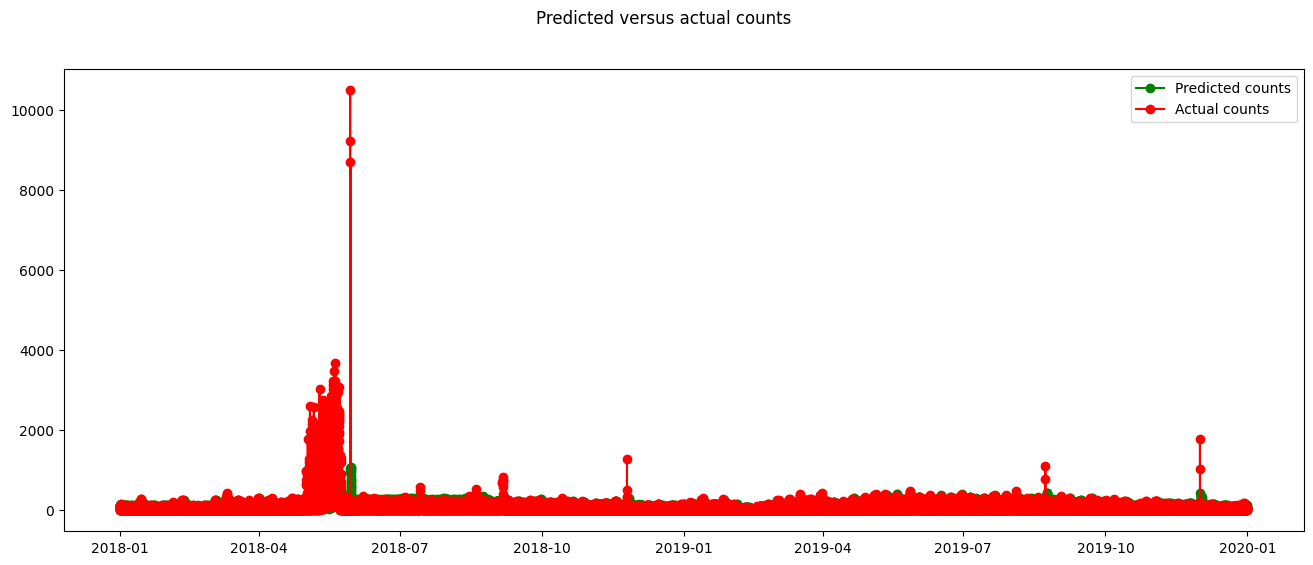

In [ ]:
plot_lstm_predictions(df_test, preds)

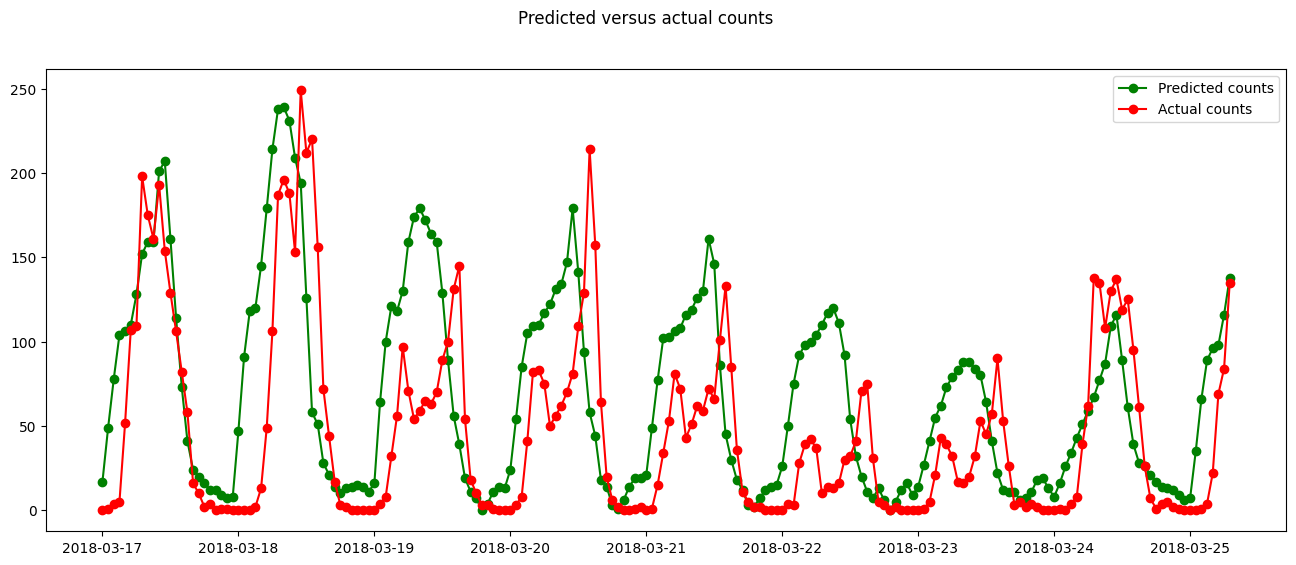

In [ ]:
plot_lstm_predictions(df_test, preds[1800:2000], start_index=1800, end_index=2000)

In [ ]:
calculate_metrics(y_class, pred_class)

{'balanced_acc': 0.689, 'precision': 0.845, 'recall': 0.379}